In [1]:
! pip install numpy
! pip install mdptoolbox-hiive
! pip install gym
! pip install pymdptoolbox
! pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import hiive.mdptoolbox 
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import gym
import matplotlib.pyplot as plt
import time
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
import random
import binascii
from matplotlib.pyplot import figure


In [3]:
#Generate a 25x25 random frozen lake environment. 
# 90% of tiles will be frozen.  10% of tiles will be holes.
# The ice is slipery.  There is a 33% chance of successfully moving in the direction taken, and a 33% chance each of slipping in one of the perpendicular directions
random.seed(10)
lakesize = 25
random_map = generate_random_map(size=lakesize, p=0.9)
env = FrozenLakeEnv(desc=random_map)

obs_space = env.observation_space
action_space = env.action_space
s=env.reset()
#print(env.P[5])


In [34]:
nA, nS = env.action_space.n, env.observation_space.n
P_fl = np.zeros([nA, nS, nS])
R_fl = np.zeros([nS, nA])
for s in range(nS):
    for a in range(nA):
        transitions = env.P[s][a]
        for p_trans, next_s, reward, _ in transitions:
            P_fl[a,s,next_s] += p_trans
            R_fl[s,a] = reward
        P_fl[a,s,:] /= np.sum(P_fl[a,s,:])


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


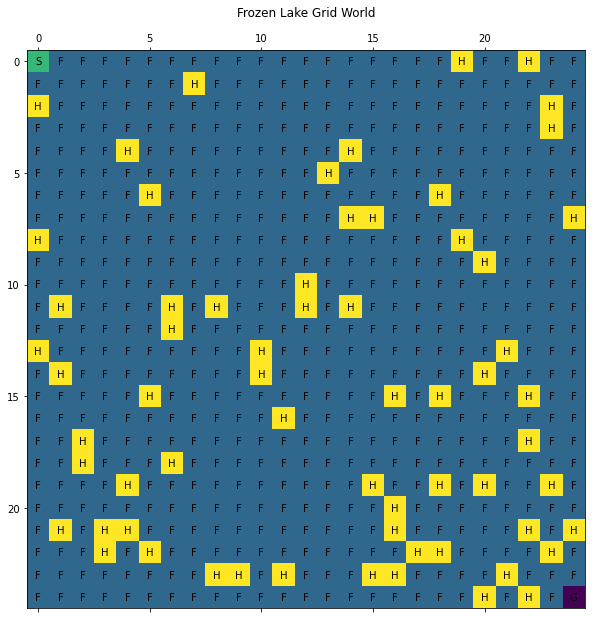

In [5]:
#plot lake map
# green = start
# purple = goal
# blue = frozen
# yellow = hole

lake=env.desc.shape
lakemap = np.zeros(lake)
for r in range(lake[0]):
   for c in range(lake[1]):
     ss=env.desc[r][c]
     if ss == b'S': i=2
     elif ss == b'F': i=1
     elif ss == b'H': i=3
     else: i=0
     lakemap[r][c] = i

plt.matshow(lakemap)

plt.rcParams['figure.figsize'] = (10, 10)

for r in range(lakesize):
    for c in range(lakesize):
        e = env.desc[r][c]
        st = e.decode()
        plt.text(c, r, st, va='center', ha='center')

plt.title('Frozen Lake Grid World')
plt.show()
#print(lakemap)

In [61]:
def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var, 'o-')
    plt.show()

def plot_data_legend(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    colors = ['red','orange','black','green','blue','violet']
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
#         if i == 2: # don't plot when i = 1 for cv
#             x_vars = x_vars[1:]
        plt.plot(x_vars, y_var, 'o-', color=colors[i % 6], label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend()
    plt.show()

def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

In [6]:
VI_mdp = hiive.mdptoolbox.mdp.ValueIteration(P_fl, R_fl, 0.99, epsilon=0.001, max_iter=10000, skip_check=True)
VI_mdp.run()
print('Iterations: ', VI_mdp.iter)
print('CPU Time: ', VI_mdp.time)

VI_policymap = list(VI_mdp.policy)
VI_policyarray = np.reshape(VI_policymap,(lakesize,lakesize)) 
VI_valuemap = list(VI_mdp.V)
VI_valuearray = np.reshape(VI_valuemap,(lakesize,lakesize)) 

#print(VI_mdp.policy)
#print(policyarray)
#print(VI_mdp.V)
#print(valuearray)


Iterations:  298
CPU Time:  0.15407466888427734


Text(0.5, 1.05, 'Frozen Lake - Value Iteration, Policy Map')

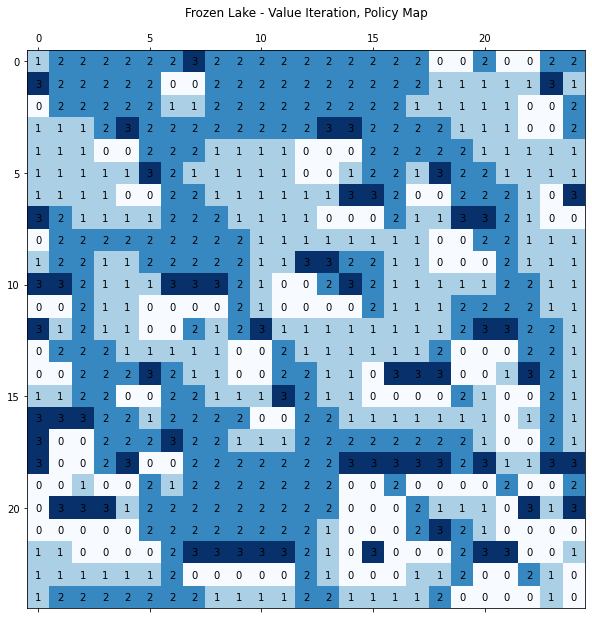

In [16]:
# VI Policy map

plt.matshow(VI_policyarray, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(lakesize):
    for j in range(lakesize):
        e = VI_policyarray[i][j]
        st = str(e)
        plt.text(j, i, st, va='center', ha='center')
plt.title('Frozen Lake - Value Iteration, Policy Map')

Text(0.5, 1.05, 'Frozen Lake - Value Iteration, Value Map')

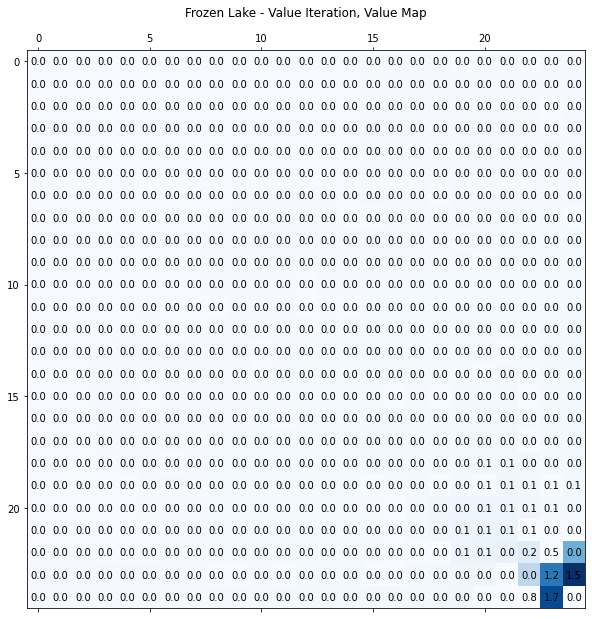

In [17]:
# VI value map
plt.matshow(VI_valuearray, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(lakesize):
    for j in range(lakesize):
        e = VI_valuearray[i][j]
        st = "{v:.1f}".format(v=e)
        plt.text(i+0.0, j+0.0, st, va='center', ha='center')
plt.title('Frozen Lake - Value Iteration, Value Map')

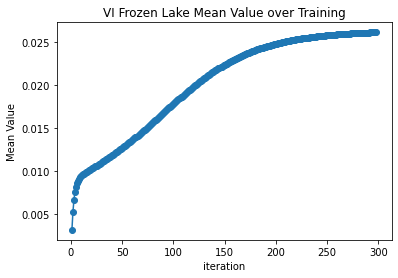

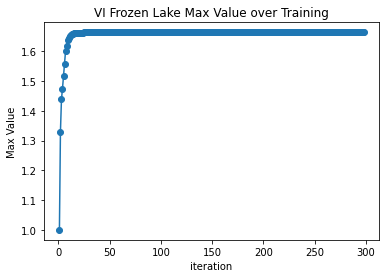

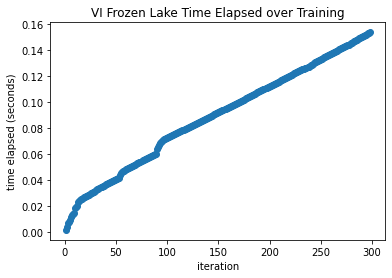

In [63]:
VI_curated_results = make_time_array(VI_mdp.run_stats, ["Mean V", "Max V", "Iteration"])
num_iters = len(VI_curated_results["Mean V"])
plot_simple_data(VI_curated_results["Iteration"], VI_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(VI_curated_results["Iteration"], VI_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake Max Value over Training", figure_size=(6,4))
plot_simple_data(VI_curated_results["Iteration"], VI_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))

In [ ]:
#
# Polict Iteration
#

PI_mdp = hiive.mdptoolbox.mdp.PolicyIterationModified(P_fl, R_fl, 0.99, epsilon = 0.001, max_iter=100, skip_check=True)
PI_mdp.run()
print('Iterations: ', PI_mdp.iter)
print('CPU Time: ', PI_mdp.time)

PI_policymap = list(PI_mdp.policy)
PI_policyarray = np.reshape(PI_policymap,(lakesize,lakesize)) 
PI_valuemap = list(PI_mdp.V)
PI_valuearray = np.reshape(PI_valuemap,(lakesize,lakesize)) 


Text(0.5, 1.05, 'Frozen Lake - Policy Iteration, Policy Map')

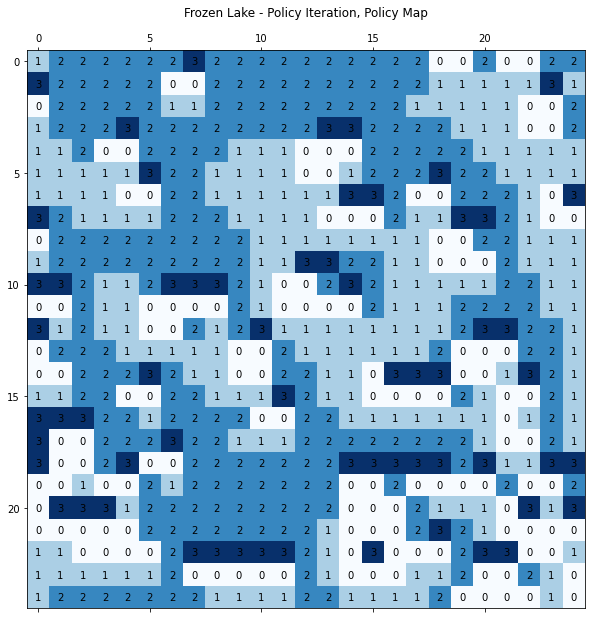

In [73]:
# PI Policy map

plt.matshow(PI_policyarray, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(lakesize):
    for j in range(lakesize):
        e = PI_policyarray[i][j]
        st = str(e)
        plt.text(j, i, st, va='center', ha='center')
plt.title('Frozen Lake - Policy Iteration, Policy Map')

Text(0.5, 1.05, 'Frozen Lake - Policy Iteration, Value Map')

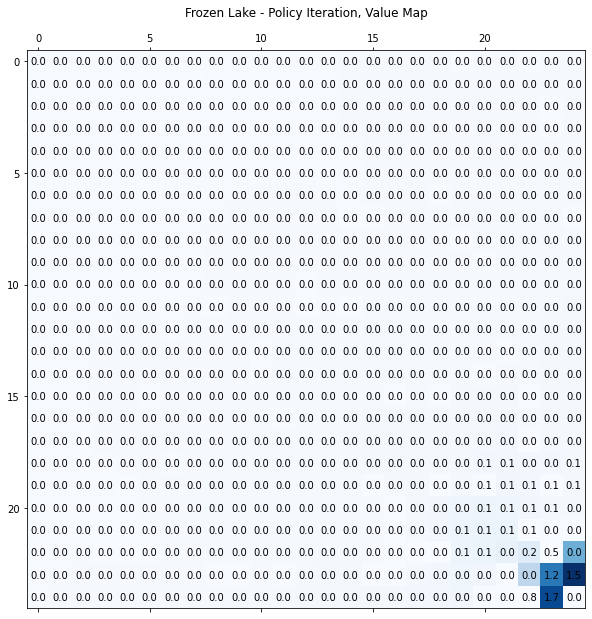

In [74]:
# PI value map
plt.matshow(PI_valuearray, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(lakesize):
    for j in range(lakesize):
        e = PI_valuearray[i][j]
        st = "{v:.1f}".format(v=e)
        plt.text(i+0.0, j+0.0, st, va='center', ha='center')
plt.title('Frozen Lake - Policy Iteration, Value Map')

In [76]:
PI_curated_results = make_time_array(PI_mdp.run_stats, ["Mean V", "Max V", "Iteration"])
num_iters = len(PI_curated_results["Mean V"])
plot_simple_data(PI_curated_results["Iteration"], PI_curated_results["Mean V"], 
                 "iteration", "Mean Value", "PI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(PI_curated_results["Iteration"], PI_curated_results["Max V"], 
                 "iteration", "Max Value", "PI Frozen Lake Max Value over Training", figure_size=(6,4))
plot_simple_data(PI_curated_results["Iteration"], PI_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "PI Frozen Lake Time Elapsed over Training", figure_size=(6,4))

TypeError: ignored

In [57]:
Q_mdp = hiive.mdptoolbox.mdp.QLearning(P_fl, R_fl, 0.99, n_iter=1000000, skip_check=True)
st = time.time()
Q_mdp.run()
end = time.time()
print('CPU Time: ',end-st)

CPU Time:  187.04962062835693


In [58]:

Q_policymap = list(Q_mdp.policy)
Q_policyarray = np.reshape(Q_policymap,(lakesize,lakesize)) 
Q_valuemap = list(Q_mdp.V)
Q_valuearray = np.reshape(Q_valuemap,(lakesize,lakesize)) 

Text(0.5, 1.05, 'Frozen Lake - Q-learning, Policy Map')

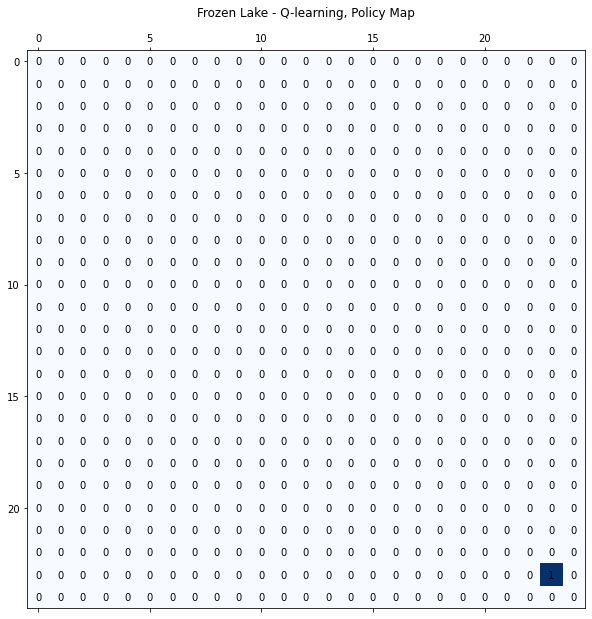

In [59]:
# PIQ Policy map

plt.matshow(Q_policyarray, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(lakesize):
    for j in range(lakesize):
        e = Q_policyarray[i][j]
        st = str(e)
        plt.text(j, i, st, va='center', ha='center')
plt.title('Frozen Lake - Q-learning, Policy Map')

Text(0.5, 1.05, 'Frozen Lake - Q-learning, Value Map')

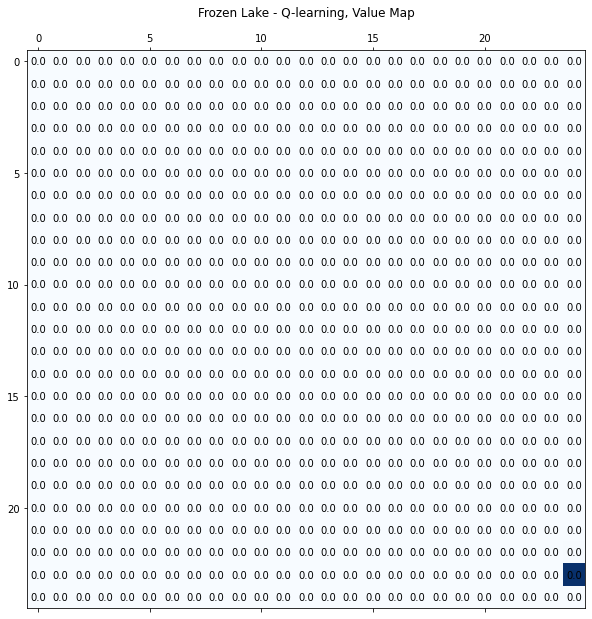

In [60]:
# Q value map
plt.matshow(Q_valuearray, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(lakesize):
    for j in range(lakesize):
        e = Q_valuearray[i][j]
        st = "{v:.1f}".format(v=e)
        plt.text(i+0.0, j+0.0, st, va='center', ha='center')
plt.title('Frozen Lake - Q-learning, Value Map')